In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure output directory exists
os.makedirs('charts', exist_ok=True)

# Data Preprocessing
def preprocess_data(df, is_train=True, encoder=None, scaler=None):
    """Preprocess the dataset for training or inference."""
    df = df.copy()
    
    # Drop redundant Age_Group for modeling
    df = df.drop(columns=['Age_Group'])
    
    # Define feature groups
    categorical_cols = ['Gender', 'Race', 'Employment_Type', 'Education_Level', 
                       'Citizenship_Status', 'Language_Proficiency', 
                       'Disability_Status', 'Criminal_Record', 'Zip_Code_Group']
    numerical_cols = ['Age', 'Income', 'Credit_Score', 'Loan_Amount']
    
    # Encode categorical variables
    if is_train:
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
        encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
    else:
        encoded_cols = pd.DataFrame(encoder.transform(df[categorical_cols]))
        encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
    
    # Scale numerical features
    if is_train:
        scaler = StandardScaler()
        scaled_cols = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), 
                                  columns=numerical_cols)
    else:
        scaled_cols = pd.DataFrame(scaler.transform(df[numerical_cols]), 
                                  columns=numerical_cols)
    
    # Combine features
    features = pd.concat([scaled_cols, encoded_cols], axis=1)
    return features, encoder, scaler

# Model Training
def train_model(X, y):
    """Train a Logistic Regression model."""
    model = LogisticRegression(random_state=42)
    model.fit(X, y)
    return model

# Bias Auditing
def audit_bias(model, X, y, sensitive_features):
    """Audit model for bias using fairness metrics."""
    predictions = model.predict(X)
    metrics = {
        'accuracy': accuracy_score,
        'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
        'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=0),
        'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=0)
    }
    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y,
        y_pred=predictions,
        sensitive_features=sensitive_features
    )
    
    # Fairness metrics
    dpd = demographic_parity_difference(y, predictions, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y, predictions, sensitive_features=sensitive_features)
    
    return metric_frame, dpd, eod

# Visualization
def create_visualizations(X, y, model, sensitive_features, output_dir='charts'):
    """Create visualizations for bias analysis."""
    df = pd.concat([sensitive_features, pd.Series(y, name='Loan_Approved')], axis=1)
    
    # Approval rates by group
    for col in ['Gender', 'Race', 'Age_Group']:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Loan_Approved', y=col, hue=col, data=df)
        plt.title(f'Loan Approval Rates by {col}')
        plt.savefig(f'{output_dir}/approval_rates_{col.lower()}.png')
        plt.close()
    
    # SHAP feature importance
    explainer = shap.LinearExplainer(model, X)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Feature Importance')
    plt.savefig(f'{output_dir}/shap_importance.png')
    plt.close()
    
    # Main bias visualization (combined approval rates)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Loan_Approved', y='Gender', hue='Race', data=df)
    plt.title('Loan Approval Rates by Gender and Race')
    plt.savefig(f'{output_dir}/bias_visualization.png')
    plt.close()

C:\Users\karti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install shap seaborn fairlearn -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\karti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
train_df = pd.read_csv('data/loan_access_dataset.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
train_df['Loan_Approved'] = train_df['Loan_Approved'].map({'Denied': 0, 'Approved': 1})

In [5]:
X, encoder, scaler = preprocess_data(train_df)
y = train_df['Loan_Approved']

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
model = train_model(X_train, y_train)

In [8]:
sensitive_features = train_df.loc[y_val.index, ['Gender', 'Race', 'Age_Group', 
                                                 'Zip_Code_Group', 'Citizenship_Status', 
                                                 'Criminal_Record']]
metric_frame, dpd, eod = audit_bias(model, X_val, y_val, sensitive_features)

In [9]:
create_visualizations(X_val, y_val, model, sensitive_features)

In [10]:
X_test, _, _ = preprocess_data(test_df, is_train=False, encoder=encoder, scaler=scaler)
predictions = model.predict(X_test)
submission = pd.DataFrame({'ID': test_df['ID'], 'Loan_Approved': predictions})
submission['Loan_Approved'] = submission['Loan_Approved'].map({0: 'Denied', 1: 'Approved'})

In [11]:
print("Fairness Metrics:")
print(f"Demographic Parity Difference: {dpd:.3f}")
print(f"Equalized Odds Difference: {eod:.3f}")

Fairness Metrics:
Demographic Parity Difference: 1.000
Equalized Odds Difference: 1.000


In [12]:
metric_frame.by_group

accuracy  \
Gender     Race  Age_Group Zip_Code_Group       Citizenship_Status Criminal_Record             
Female     Asian 25-60     High-income Suburban Citizen            No               0.833333   
                                                                   Yes              0.000000   
                                                Permanent Resident No               1.000000   
                                                                   Yes                   NaN   
                                                Visa Holder        No                    NaN   
...                                                                                      ...   
Non-binary White Under 25  Working Class Urban  Citizen            Yes                   NaN   
                                                Permanent Resident No                    NaN   
                                                                   Yes                   NaN   
                                                Visa Holder        No                    NaN   
                                                                   Yes                   NaN   

                                                                                    precision  \
Gender     Race  Age_Group Zip_Code_Group       Citizenship_Status Criminal_Record              
Female     Asian 25-60     High-income Suburban Citizen            No                     1.0   
                                                                   Yes                    0.0   
                                                Permanent Resident No                     0.0   
                                                                   Yes                    NaN   
                                                Visa Holder        No                     NaN   
...                                                                                       ...   
Non-binary White Under 25  Working Class Urban  Citizen            Yes                    NaN   
                                                Permanent Resident No                     NaN   
                                                                   Yes                    NaN   
                                                Visa Holder        No                     NaN   
                                                                   Yes                    NaN   

                                                                                      recall  \
Gender     Race  Age_Group Zip_Code_Group       Citizenship_Status Criminal_Record             
Female     Asian 25-60     High-income Suburban Citizen            No               0.666667   
                                                                   Yes              0.000000   
                                                Permanent Resident No               0.000000   
                                                                   Yes                   NaN   
                                                Visa Holder        No                    NaN   
...                                                                                      ...   
Non-binary White Under 25  Working Class Urban  Citizen            Yes                   NaN   
                                                Permanent Resident No                    NaN   
                                                                   Yes                   NaN   
                                                Visa Holder        No                    NaN   
                                                                   Yes                   NaN   

                                                                                     f1  
Gender     Race  Age_Group Zip_Code_Group       Citizenship_Status Criminal_Record       
Female     Asian 25-60     High-income Suburban Citizen            No               0.8  
                                                      

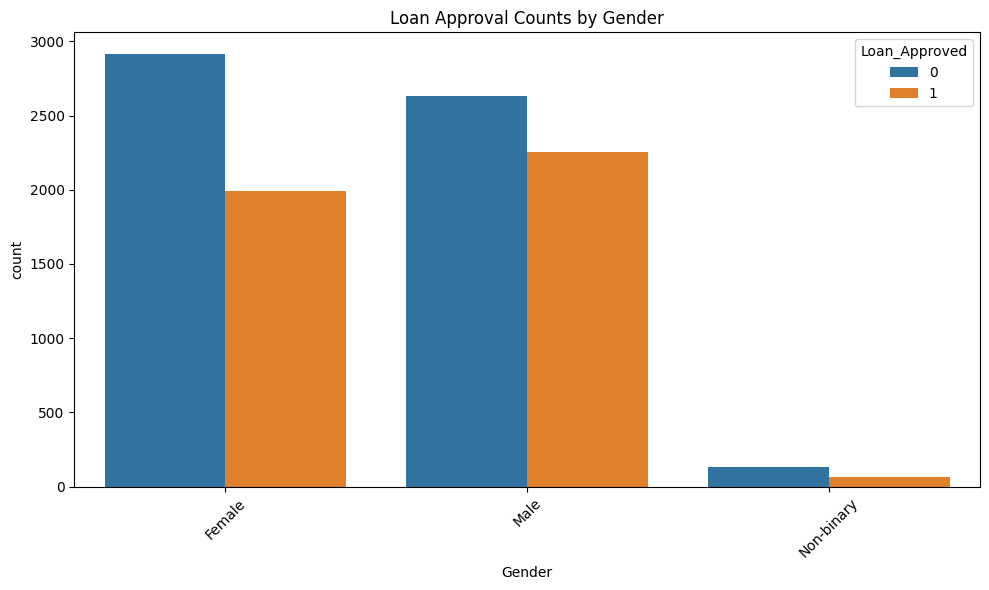

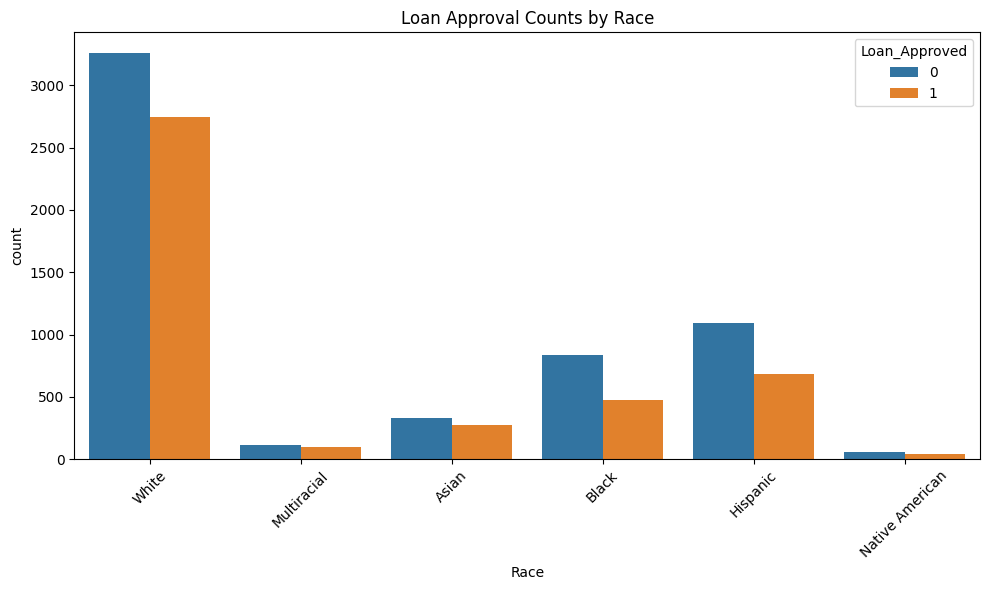

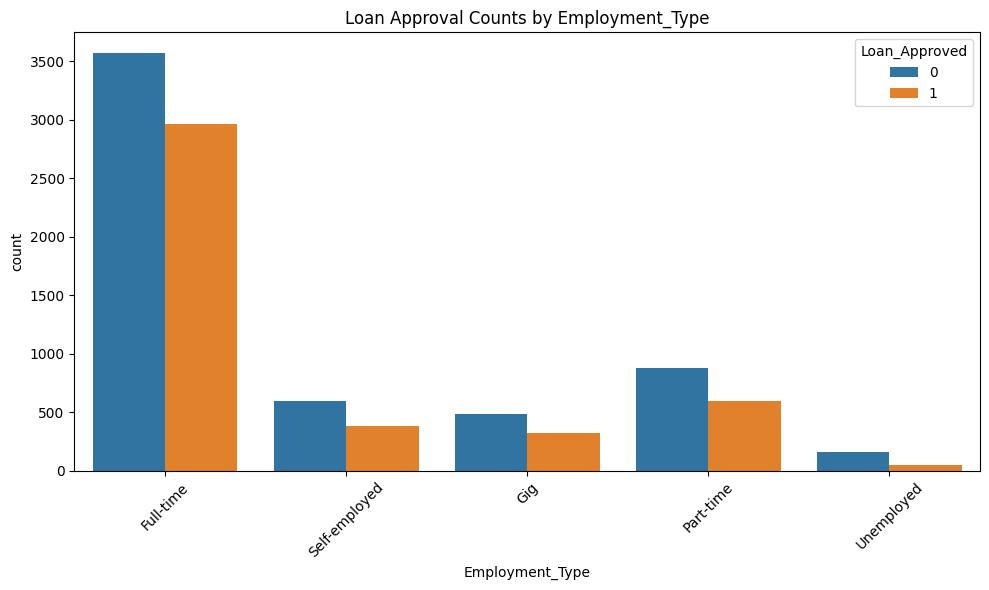

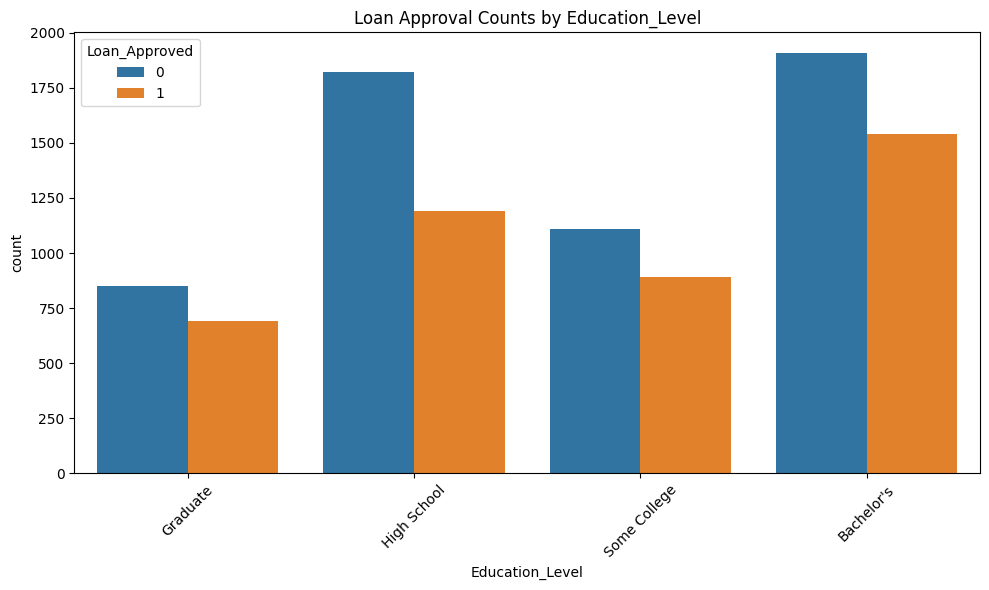

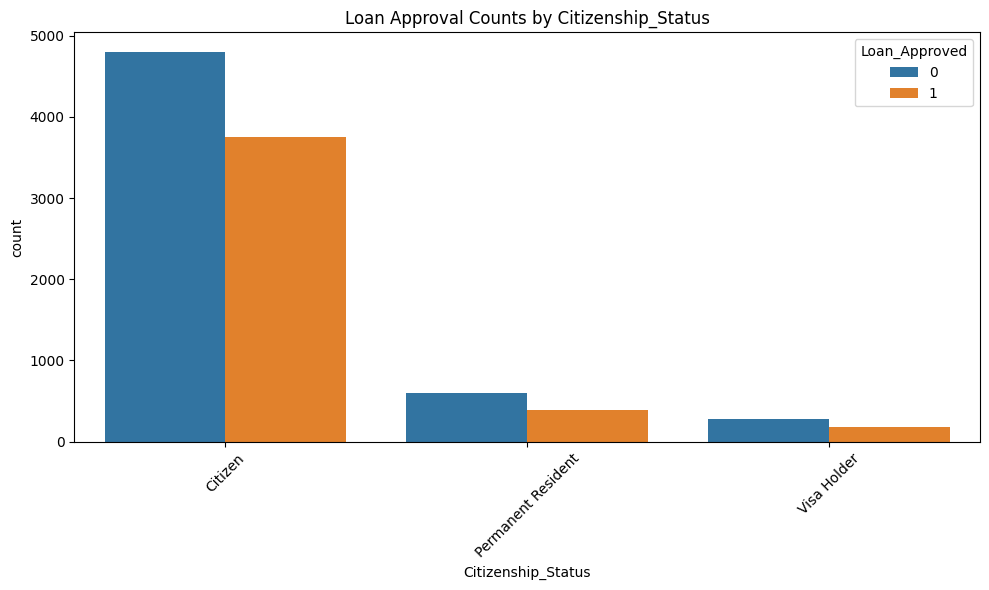

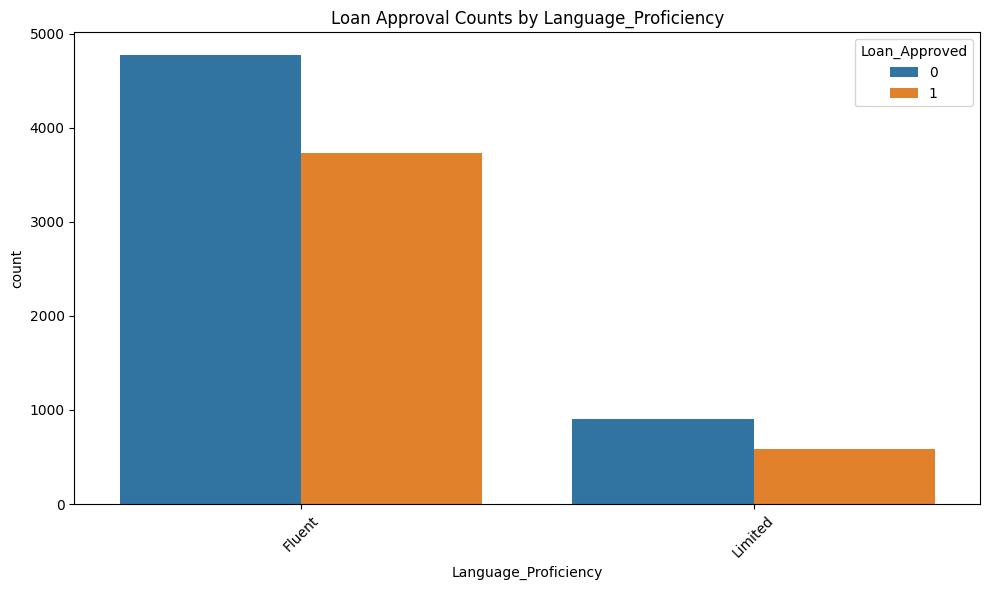

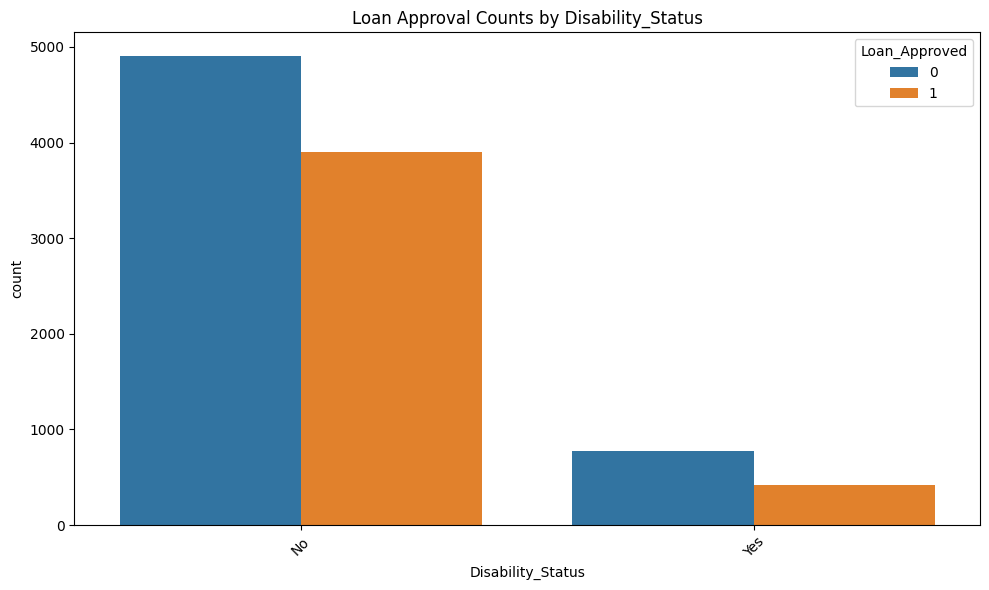

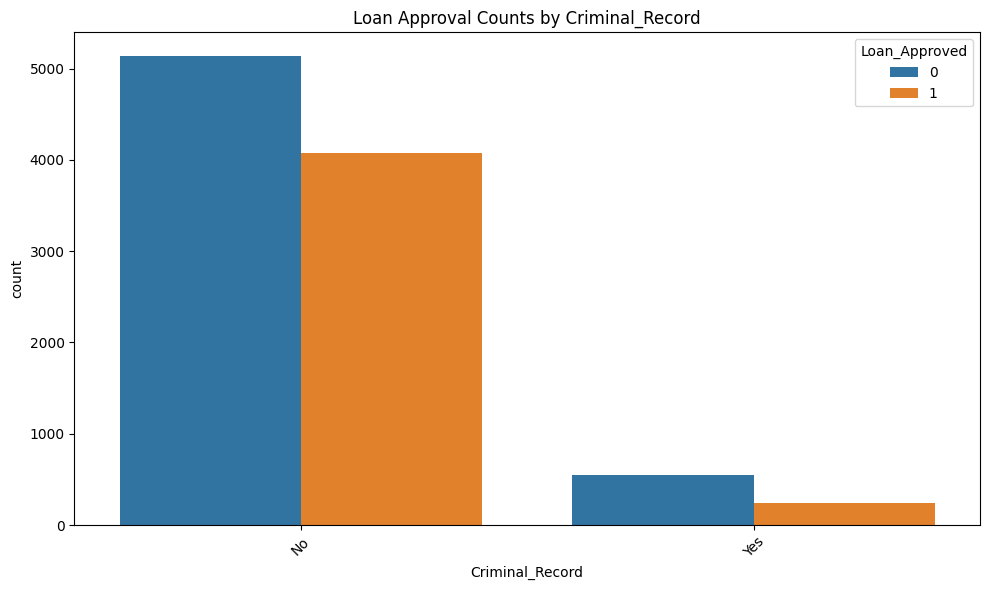

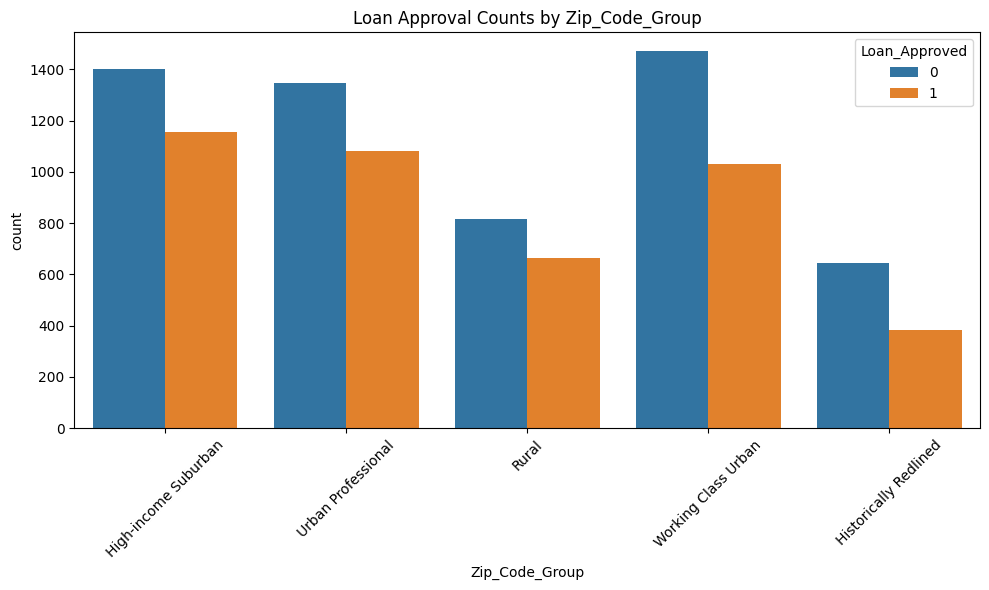

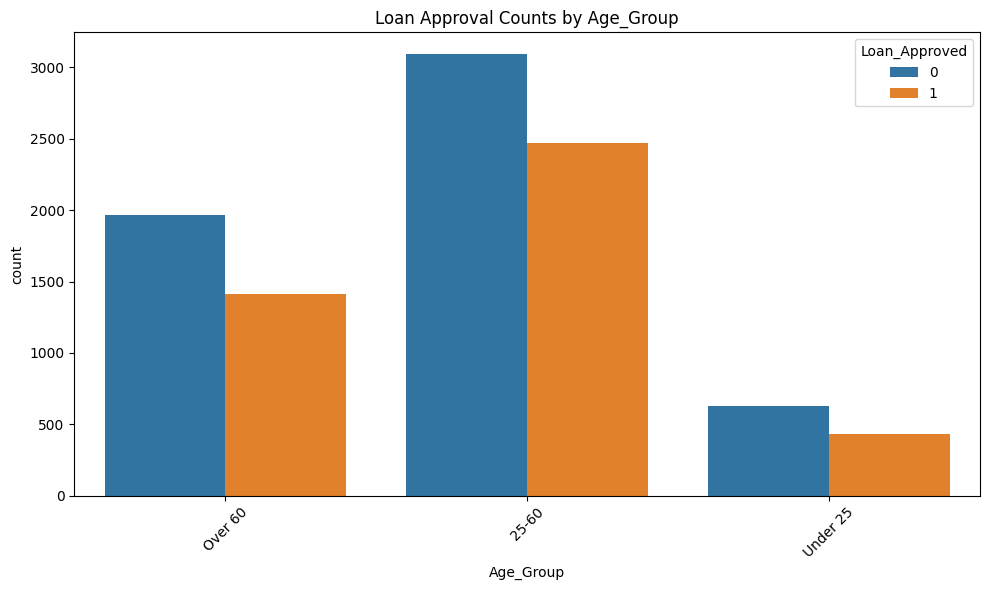

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical columns (excluding target)
categorical_cols = ['Gender', 'Race', 'Employment_Type', 'Education_Level', 
                    'Citizenship_Status', 'Language_Proficiency', 
                    'Disability_Status', 'Criminal_Record', 'Zip_Code_Group', 'Age_Group']

# Create plots
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_df, x=col, hue='Loan_Approved')
    plt.title(f'Loan Approval Counts by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'charts/loan_approval_by_{col.lower()}.png')
    plt.show()
    plt.close()

In [ ]:
!pip install shap seaborn fairlearn xgboost -q

import pandas as pd
import numpy as np
import os
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference

# Create output directory
os.makedirs('charts', exist_ok=True)

# -------------------------------
# Data Preprocessing
# -------------------------------
def preprocess_data(df, is_train=True, encoder=None, scaler=None):
    df = df.copy()
    df = df.drop(columns=['Age_Group'], errors='ignore')
    
    categorical_cols = ['Gender', 'Race', 'Employment_Type', 'Education_Level', 
                        'Citizenship_Status', 'Language_Proficiency', 
                        'Disability_Status', 'Criminal_Record', 'Zip_Code_Group']
    numerical_cols = ['Age', 'Income', 'Credit_Score', 'Loan_Amount']
    
    if is_train:
        encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
        encoded = encoder.fit_transform(df[categorical_cols])
    else:
        encoded = encoder.transform(df[categorical_cols])
        
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    
    if is_train:
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df[numerical_cols])
    else:
        scaled = scaler.transform(df[numerical_cols])
        
    scaled_df = pd.DataFrame(scaled, columns=numerical_cols, index=df.index)
    
    features = pd.concat([scaled_df, encoded_df], axis=1)
    return features, encoder, scaler

# -------------------------------
# Train Models and Evaluate
# -------------------------------
def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    models = {
        "logistic": LogisticRegression(random_state=42, max_iter=1000),
        "xgboost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        acc = accuracy_score(y_val, val_pred)
        print(f"{name} validation accuracy: {acc:.4f}")
        scores[name] = (model, acc)
    
    best_model_name = max(scores, key=lambda k: scores[k][1])
    best_model = scores[best_model_name][0]
    print(f"\n✅ Best model selected: {best_model_name.upper()}")

    return best_model

# -------------------------------
# Fairness Auditing
# -------------------------------
def audit_bias(model, X, y, sensitive_features):
    predictions = model.predict(X)
    
    metrics = {
        'accuracy': accuracy_score,
        'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
        'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=0),
        'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=0)
    }
    
    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y,
        y_pred=predictions,
        sensitive_features=sensitive_features
    )
    
    dpd = demographic_parity_difference(y, predictions, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y, predictions, sensitive_features=sensitive_features)
    
    return metric_frame, dpd, eod

# -------------------------------
# Visualization
# -------------------------------
def create_visualizations(X, y, model, sensitive_features, output_dir='charts'):
    df = pd.concat([sensitive_features.reset_index(drop=True), pd.Series(y, name='Loan_Approved')], axis=1)
    
    for col in ['Gender', 'Race', 'Age_Group']:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=col, y='Loan_Approved', data=df, estimator=lambda x: np.mean(x)*100)
        plt.ylabel('Approval Rate (%)')
        plt.title(f'Loan Approval Rates by {col}')
        plt.savefig(f'{output_dir}/approval_rates_{col.lower()}.png')
        plt.close()
    
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Feature Importance')
    plt.savefig(f'{output_dir}/shap_importance.png')
    plt.close()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Gender', y='Loan_Approved', hue='Race', data=df, estimator=lambda x: np.mean(x)*100)
    plt.ylabel('Approval Rate (%)')
    plt.title('Loan Approval Rates by Gender and Race')
    plt.savefig(f'{output_dir}/bias_visualization.png')
    plt.close()

# -------------------------------
# Main
# -------------------------------
if __name__ == "__main__":
    # Load data
    train_df = pd.read_csv("data/loan_access_dataset.csv")
    test_df = pd.read_csv("data/test.csv")
    
    train_df['Loan_Approved'] = train_df['Loan_Approved'].map({'Denied': 0, 'Approved': 1})

    # Preprocess
    X, encoder, scaler = preprocess_data(train_df)
    y = train_df['Loan_Approved']

    # Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Train and evaluate both models
    best_model = train_and_evaluate_models(X_train, y_train, X_val, y_val)

    # Bias audit
    sensitive_features = train_df.loc[y_val.index, ['Gender', 'Race', 'Age_Group', 
                                                    'Zip_Code_Group', 'Citizenship_Status', 
                                                    'Criminal_Record']]
    metric_frame, dpd, eod = audit_bias(best_model, X_val, y_val, sensitive_features)

    print("\nFairness Metrics:")
    print(f"Demographic Parity Difference: {dpd:.4f}")
    print(f"Equalized Odds Difference: {eod:.4f}")
    print("\nPerformance by Group:")
    print(metric_frame.by_group)

    # Visualize
    create_visualizations(X_val, y_val, best_model, sensitive_features)

    # Predict on test data
    X_test, _, _ = preprocess_data(test_df, is_train=False, encoder=encoder, scaler=scaler)
    predictions = best_model.predict(X_test)

    submission = pd.DataFrame({'ID': test_df['ID'], 'Loan_Approved': predictions})
    submission['Loan_Approved'] = submission['Loan_Approved'].map({0: 'Denied', 1: 'Approved'})




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\karti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


logistic validation accuracy: 0.6390


C:\Users\karti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:02:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


xgboost validation accuracy: 0.5880

✅ Best model selected: LOGISTIC

Fairness Metrics:
Demographic Parity Difference: 1.0000
Equalized Odds Difference: 1.0000

Performance by Group:
                                                                                    accuracy  \
Gender     Race  Age_Group Zip_Code_Group       Citizenship_Status Criminal_Record             
Female     Asian 25-60     High-income Suburban Citizen            No               0.833333   
                                                                   Yes              0.000000   
                                                Permanent Resident No               1.000000   
                                                                   Yes                   NaN   
                                                Visa Holder        No                    NaN   
...                                                                                      ...   
Non-binary White Under 25  Working Class Urban  C

In [18]:
!pip install imblearn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import logging
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
import joblib

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ensure charts folder exists
os.makedirs('charts', exist_ok=True)

# -------------------------------
# Data Preprocessing
# -------------------------------
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
        self.categorical_cols = ['Gender', 'Race', 'Employment_Type', 'Education_Level',
                                'Citizenship_Status', 'Language_Proficiency',
                                'Disability_Status', 'Criminal_Record', 'Zip_Code_Group']
        self.numerical_cols = ['Age', 'Income', 'Credit_Score', 'Loan_Amount']
        self.fitted = False

    def preprocess(self, df, is_train=True):
        """Preprocess the dataset, returning features and sensitive attributes."""
        logging.info("Starting preprocessing (is_train=%s)", is_train)
        df = df.copy()
        
        # Drop redundant feature
        df = df.drop(columns=['Age_Group'], errors='ignore')
        
        # Feature engineering
        df['Income_to_Loan_Ratio'] = df['Income'] / (df['Loan_Amount'] + 1e-6)
        numerical_cols = self.numerical_cols + ['Income_to_Loan_Ratio']
        
        # Check for NaN in input
        if df[numerical_cols].isna().any().any():
            raise ValueError(f"NaN in numerical columns: {df[numerical_cols].columns[df[numerical_cols].isna().any()].tolist()}")
        if df[self.categorical_cols].isna().any().any():
            raise ValueError(f"NaN in categorical columns: {df[self.categorical_cols].columns[df[self.categorical_cols].isna().any()].tolist()}")
        
        # Extract sensitive features for auditing
        sensitive_features = df[['Gender', 'Race', 'Zip_Code_Group', 'Citizenship_Status', 'Criminal_Record']].copy()
        
        # Encode categorical features
        if is_train:
            self.fitted = True
            encoded = self.encoder.fit_transform(df[self.categorical_cols])
            encoded_cols = self.encoder.get_feature_names_out(self.categorical_cols)
            encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
        else:
            if not self.fitted:
                raise ValueError("Preprocessor must be fitted on training data first")
            try:
                encoded = self.encoder.transform(df[self.categorical_cols])
                encoded_cols = self.encoder.get_feature_names_out(self.categorical_cols)
                encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
            except ValueError as e:
                raise ValueError(f"Unknown categories in test data: {str(e)}")
        
        # Check for NaN after encoding
        if encoded_df.isna().any().any():
            raise ValueError(f"NaN in encoded columns: {encoded_df.columns[encoded_df.isna().any()].tolist()}")
        
        # Scale numerical features
        if is_train:
            scaled = self.scaler.fit_transform(df[numerical_cols])
        else:
            scaled = self.scaler.transform(df[numerical_cols])
        scaled_df = pd.DataFrame(scaled, columns=numerical_cols, index=df.index)
        
        # Check for NaN after scaling
        if scaled_df.isna().any().any():
            raise ValueError(f"NaN in scaled columns: {scaled_df.columns[scaled_df.isna().any()].tolist()}")
        
        # Combine features
        features = pd.concat([scaled_df, encoded_df], axis=1)
        
        if is_train:
            X = features
            y = df['Loan_Approved']
            if X.isna().any().any() or y.isna().any():
                raise ValueError("NaN in features or target")
            logging.info("Preprocessing complete: X shape=%s, y shape=%s", X.shape, y.shape)
            return X, y, sensitive_features
        else:
            logging.info("Preprocessing complete: X shape=%s", features.shape)
            return features, sensitive_features

# -------------------------------
# Model Training
# -------------------------------
class ModelTrainer:
    def __init__(self):
        self.models = {
            'logistic': LogisticRegression(random_state=42, max_iter=1000),
            'xgboost': XGBClassifier(random_state=42, eval_metric='logloss')
        }
        self.best_model = None

    def train(self, X, y):
        """Train and select the best model with SMOTE."""
        logging.info("Starting model training")
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        
        # Apply SMOTE to training data only
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        
        best_score = 0
        for name, model in self.models.items():
            model.fit(X_train_res, y_train_res)
            score = model.score(X_val, y_val)
            logging.info("%s validation accuracy: %.4f", name, score)
            print(f"{name} validation accuracy: {score:.4f}")
            if score > best_score:
                self.best_model = model
                best_score = score
        joblib.dump(self.best_model, 'best_model.pkl')
        logging.info("Model training complete, best model saved")
        return self.best_model, X_val, y_val

# -------------------------------
# Fairness Auditing
# -------------------------------
def audit_bias(model, X, y, sensitive_features):
    """Audit model for fairness, handling one sensitive feature at a time."""
    logging.info("Starting fairness audit")
    predictions = model.predict(X)
    
    metrics = {
        'accuracy': accuracy_score,
        'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
        'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=0),
        'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=0)
    }
    
    results = {}
    for col in ['Gender', 'Race', 'Zip_Code_Group']:
        # Filter groups with sufficient samples
        group_counts = sensitive_features[col].value_counts()
        valid_groups = group_counts[group_counts >= 10].index
        valid_mask = sensitive_features[col].isin(valid_groups)
        X_valid = X[valid_mask]
        y_valid = y[valid_mask]
        predictions_valid = predictions[valid_mask]
        sensitive_valid = sensitive_features[col][valid_mask]
        
        if len(valid_groups) < 2:
            logging.warning("Skipping %s: insufficient groups with enough samples", col)
            continue
        
        metric_frame = MetricFrame(
            metrics=metrics,
            y_true=y_valid,
            y_pred=predictions_valid,
            sensitive_features=sensitive_valid
        )
        
        dpd = demographic_parity_difference(y_valid, predictions_valid, sensitive_features=sensitive_valid)
        eod = equalized_odds_difference(y_valid, predictions_valid, sensitive_features=sensitive_valid)
        
        results[col] = {
            'metric_frame': metric_frame,
            'dpd': dpd,
            'eod': eod
        }
    
    return results

# -------------------------------
# Visualization
# -------------------------------
def create_visualizations(X, y, model, sensitive_features, output_dir='charts'):
    """Create visualizations for bias analysis."""
    logging.info("Creating visualizations")
    df = pd.concat([sensitive_features.reset_index(drop=True), pd.Series(y, name='Loan_Approved')], axis=1)
    
    for col in ['Gender', 'Race', 'Zip_Code_Group']:
        plt.figure(figsize=(10, 6))
        approval_rates = df.groupby(col)['Loan_Approved'].agg(['mean', 'count'])
        approval_rates['mean'] *= 100  # Convert to percentage
        sns.barplot(x=approval_rates.index, y=approval_rates['mean'])
        plt.ylabel('Approval Rate (%)')
        plt.title(f'Loan Approval Rates by {col} (Sample Count)')
        for i, count in enumerate(approval_rates['count']):
            plt.text(i, approval_rates['mean'].iloc[i], f'n={count}', ha='center', va='bottom')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/approval_rates_{col.lower()}.png')
        plt.close()
    
    # SHAP feature importance
    explainer = shap.LinearExplainer(model, X, feature_perturbation='interventional')
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False, max_display=10)
    plt.title('SHAP Feature Importance')
    plt.savefig(f'{output_dir}/shap_importance.png', bbox_inches='tight')
    plt.close()
    
    # Combined Gender-Race visualization
    plt.figure(figsize=(12, 8))
    approval_rates = df.groupby(['Gender', 'Race'])['Loan_Approved'].mean().unstack() * 100
    sns.heatmap(approval_rates, annot=True, fmt='.1f', cmap='Blues')
    plt.title('Approval Rates by Gender and Race (%)')
    plt.savefig(f'{output_dir}/bias_visualization.png')
    plt.close()
    logging.info("Visualizations saved")

# -------------------------------
# Main Pipeline
# -------------------------------
if __name__ == "__main__":
    logging.info("Starting pipeline execution")
    # Load data
    try:
        train_df = pd.read_csv("data/loan_access_dataset.csv")
        test_df = pd.read_csv("data/test.csv")
    except FileNotFoundError:
        logging.error("Dataset files not found")
        raise FileNotFoundError("Ensure 'loan_access_dataset.csv' and 'test.csv' are in the working directory")
    
    # Map target
    train_df['Loan_Approved'] = train_df['Loan_Approved'].map({'Denied': 0, 'Approved': 1})
    
    # Preprocess
    preprocessor = DataPreprocessor()
    X, y, sensitive_features = preprocessor.preprocess(train_df, is_train=True)
    
    # Train models and get validation set
    trainer = ModelTrainer()
    best_model, X_val, y_val = trainer.train(X, y)
    
    # Audit bias on validation set
    sensitive_features_val = sensitive_features.loc[y_val.index]
    fairness_results = audit_bias(best_model, X_val, y_val, sensitive_features_val)
    
    # Print fairness metrics
    print("\nFairness Metrics:")
    for col, result in fairness_results.items():
        print(f"\n{col}:")
        print("Demographic Parity Difference:", result['dpd'])
        print("Equalized Odds Difference:", result['eod'])
        print("Performance by Group:")
        print(result['metric_frame'].by_group)
    
    # Create visualizations
    create_visualizations(X_val, y_val, best_model, sensitive_features_val)
    
    # Predict test data
    X_test, _ = preprocessor.preprocess(test_df, is_train=False)
    test_preds = best_model.predict(X_test)
    
    # Save submission
    submission = pd.DataFrame({
        'ID': test_df['ID'],
        'Loan_Approved': np.where(test_preds == 1, 'Approved', 'Denied')
    })
    submission.to_csv('submission.csv', index=False)
    logging.info("Submission file saved as submission.csv")
    print("\n✅ Submission file saved as 'submission.csv'")
    
    # Generate AI Risk Report
    with open('ai_risk_report.md', 'w') as f:
        f.write("# AI Risk Report: Loan Approval Bias Detection\n\n")
        f.write("## Introduction\n")
        f.write("This report analyzes biases in a loan approval model trained on `loan_access_dataset.csv`.\n\n")
        f.write("## Findings\n")
        for col, result in fairness_results.items():
            f.write(f"### {col}\n")
            f.write(f"- **Demographic Parity Difference**: {result['dpd']:.4f}\n")
            f.write(f"- **Equalized Odds Difference**: {result['eod']:.4f}\n")
            f.write(f"- **Performance by Group**:\n{result['metric_frame'].by_group.to_markdown()}\n")
        f.write("\n## Implications\n")
        f.write("- Disparities in approval rates may indicate systemic biases, affecting fairness and compliance.\n")
        f.write("- Groups with low sample sizes (e.g., Non-binary, Visa Holder) require further investigation.\n")
        f.write("\n## Recommendations\n")
        f.write("- Conduct deeper audits for sparse groups.\n")
        f.write("- Explore bias mitigation techniques (e.g., reweighing, adversarial training).\n")
        f.write("- Engage stakeholders for ethical review.\n")
    logging.info("AI Risk Report saved as ai_risk_report.md")


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\karti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
2025-07-02 16:13:24,250 - INFO - Starting pipeline execution
2025-07-02 16:13:24,272 - INFO - Starting preprocessing (is_train=True)
2025-07-02 16:13:24,301 - INFO - Preprocessing complete: X shape=(10000, 28), y shape=(10000,)
2025-07-02 16:13:24,302 - INFO - Starting model training


Defaulting to user installation because normal site-packages is not writeable


2025-07-02 16:13:24,551 - INFO - logistic validation accuracy: 0.6230
2025-07-02 16:13:24,690 - INFO - xgboost validation accuracy: 0.6000
2025-07-02 16:13:24,692 - INFO - Model training complete, best model saved
2025-07-02 16:13:24,694 - INFO - Starting fairness audit


logistic validation accuracy: 0.6230
xgboost validation accuracy: 0.6000


2025-07-02 16:13:24,897 - INFO - Creating visualizations



Fairness Metrics:

Gender:
Demographic Parity Difference: 0.42099348815766724
Equalized Odds Difference: 0.41763191763191765
Performance by Group:
            accuracy  precision    recall        f1
Gender                                             
Female      0.622439   0.546512  0.550351  0.548425
Male        0.621535   0.559415  0.728571  0.632885
Non-binary  0.675676   0.833333  0.312500  0.454545

Race:
Demographic Parity Difference: 0.18538215457342538
Equalized Odds Difference: 0.2638888888888889
Performance by Group:
                 accuracy  precision    recall        f1
Race                                                    
Asian            0.587719   0.576923  0.545455  0.560748
Black            0.620209   0.452830  0.484848  0.468293
Hispanic         0.627566   0.500000  0.519685  0.509653
Multiracial      0.681818   0.650000  0.650000  0.650000
Native American  0.470588   0.444444  0.500000  0.470588
White            0.625731   0.579819  0.694946  0.632184

Zip_Code_

C:\Users\karti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
2025-07-02 16:13:25,652 - INFO - Visualizations saved
2025-07-02 16:13:25,653 - INFO - Starting preprocessing (is_train=False)
2025-07-02 16:13:25,663 - INFO - Preprocessing complete: X shape=(2500, 28)
2025-07-02 16:13:25,668 - INFO - Submission file saved as submission.csv
2025-07-02 16:13:25,673 - INFO - AI Risk Report saved as ai_risk_report.md



✅ Submission file saved as 'submission.csv'
